# Objective

Supermarket, Good Seed, wants to ensure they abide by alcohol laws by ensuring they do not sell alcohol to underage patrons. Use computer vision methods to determine the age of a customer from the cameras installed at the supermarkets checkout area (triggered when there is a purchase of alcohol).

**Goal:** Build and Evaluate a model for verifying people's age

**Steps:**
- Initialize necessary libraries for EDA
- Load and Explore the Dataset
- Exploratory Data Analysis:
    - Age distribution histogram
    - Sample images
- Modeling
  - load training path
  - load test path
  - create_model
  - train_model

# Initialization

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

# Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
# Load labels
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels.head())
display(labels.info())


# Image generator for dynamic loading
# ImageDataGenerator forms batches of images and labels dynamically to reduce memory usage
# Rescale pixel values to the [0, 1] range for neural network training
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    seed=42
)

# Sanity check
features, target = next(datagen_flow)
# Feature shapes: 4-D tensor with 16 150x150 images with 3 color channels
print("Features shape:", features.shape)
print("Sample ages:", target[:10])
print("Min pixel value:", features[0].min())
print("Max pixel value:", features[0].max())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

Found 7591 validated image filenames.
Features shape: (16, 150, 150, 3)
Sample ages: [ 1 46 35 23 47 26 20 17 25 27]
Min pixel value: 0.0
Max pixel value: 1.0


**Using 'raw' for `class_mode`**

Since the task is to predict a continuous value (real age), the problem is formulated as a regression task. Therefore, the image generator uses class_mode='raw', and the neural network outputs a single numeric value.

# EDA

In [3]:
# Look at the distribution of data
display(labels['real_age'].describe())
print('')
print("Number of images:", labels.shape[0])
print("Image shape:", features[0].shape)

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


Number of images: 7591
Image shape: (150, 150, 3)


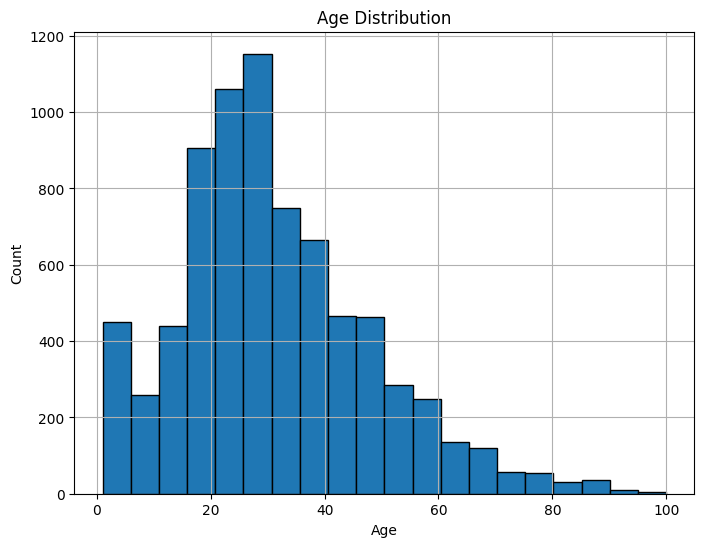

21+     5537
0-20    2054
Name: age_group, dtype: int64

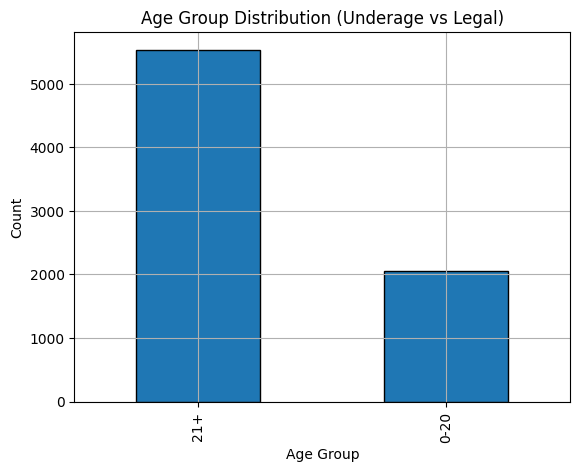

In [4]:
# Explore the age distribution
labels['real_age'].plot(
    kind='hist',
    bins=20,
    edgecolor='black',
    figsize=(8,6)
)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Create two age groups: under 21 and 21+
labels['age_group'] = pd.cut(
    labels['real_age'],
    bins=[0, 20, 100], 
    labels=['0-20','21+']
)

# Count how many in each group
age_counts = labels['age_group'].value_counts()
display(age_counts)

# Plot
age_counts.plot(kind='bar', edgecolor='black')
plt.title('Age Group Distribution (Underage vs Legal)')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.grid(True)
plt.show()



**Graph Distribution:**
- Ages **0–5**: ~450 individuals  
- Ages **6–10**: ~260 individuals  
- Ages **11–15**: ~440 individuals 
- Ages **16–20**: ~900 individuals — this group is **most at risk of attempting to purchase alcohol underage**  
- Ages **21+**: 5,537 individuals


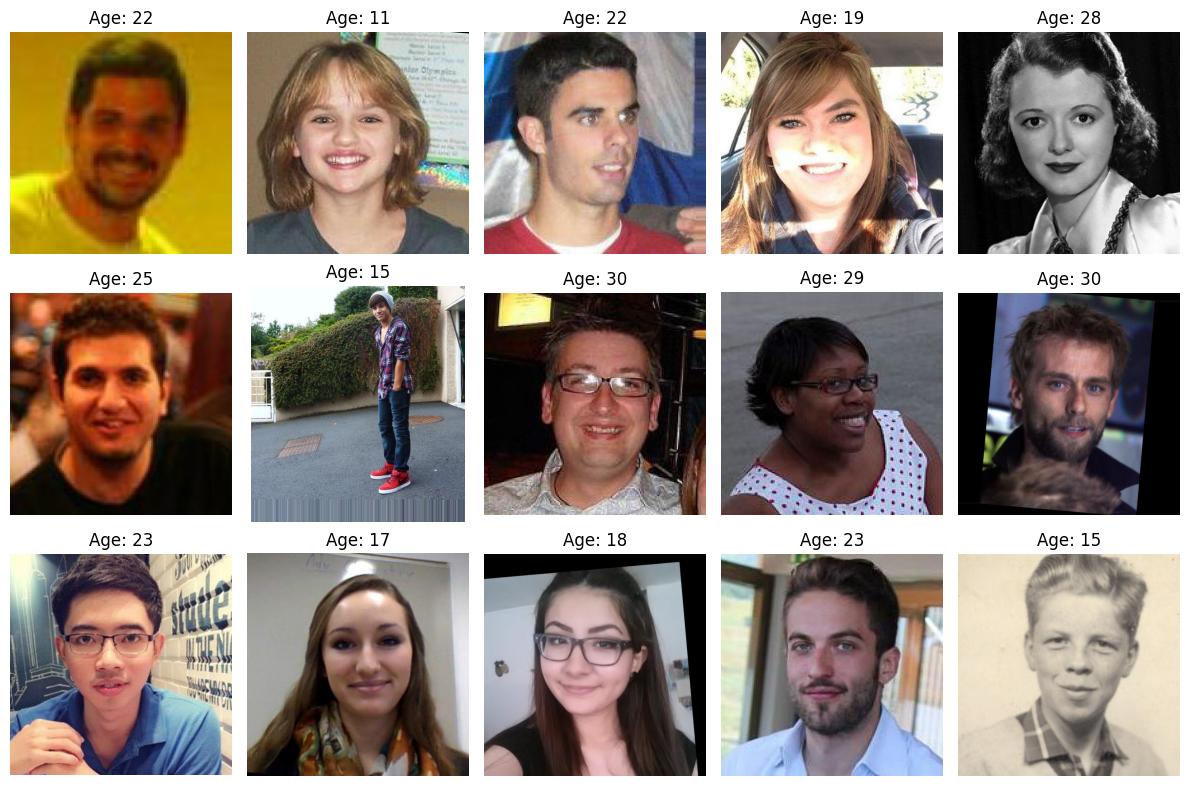

In [5]:
# Filter the labels DataFrame to include only people aged 11–31
# Then randomly select 15 rows for display
sample_labels = labels[(labels.real_age >= 11) & (labels.real_age <= 31)].sample(15)

# Create a figure to hold multiple subplots
# figsize sets the width and height of the figure in inches
plt.figure(figsize=(12, 8))

# Loop over the sampled rows
# enumerate() gives both the index (i) and the item (row) in the loop
# sample_labels.itertuples() converts each row of the DataFrame into a tuple-like object
# This allows us to access columns using row.column_name (e.g., row.file_name, row.real_age)
for i, row in enumerate(sample_labels.itertuples()):
    
    # Open the image corresponding to the current row's file name
    img = Image.open(f"/datasets/faces/final_files/{row.file_name}")
    
    # Create a subplot in a grid of 3 rows and 5 columns
    # i+1 is needed because subplot indices start at 1
    plt.subplot(3, 5, i+1)
    
    # Display the image
    plt.imshow(np.array(img))  # convert PIL image to NumPy array for matplotlib
    
    # Set the title of the subplot to the real age of the person
    plt.title(f"Age: {row.real_age}")
    
    # Remove axis ticks and labels for clarity
    plt.axis('off')

# Adjust spacing between subplots so titles and images don't overlap
plt.tight_layout()

# Display all the images in the figure
plt.show()

## Findings

### Age Distribution Insights

The dataset contains images of people with the following age distribution:

- Ages **0–5**: ~450 individuals  
- Ages **6–10**: ~260 individuals  
- Ages **11–15**: ~440 individuals - this group is **at risk of attempting to purchase alcohol underage** 
- Ages **16–20**: ~900 individuals — this group is **most at risk of attempting to purchase alcohol underage**  
- Ages **21+**: 5,537 individuals — the majority of the dataset, representing people of legal drinking age  

**Key Observations:**

1. The dataset is **heavily skewed toward adults (21+)**, which may affect model training. The model may see fewer examples of underage faces, potentially reducing accuracy for the underage group.  
2. The **16–20 age group**, though smaller, is the most important from a business perspective, so model evaluation should pay special attention to predictions in this range.  
3. Visualizing the data using both a **continuous-age histogram** and a **simplified 0–20 / 21+ bar chart** provides a clear picture of the dataset distribution for both regression modeling and business interpretation.


### Observational Insights from Sample Images

Examining a sample of 15 images (ages 11–30) reveals significant **variability between perceived age and actual age**:

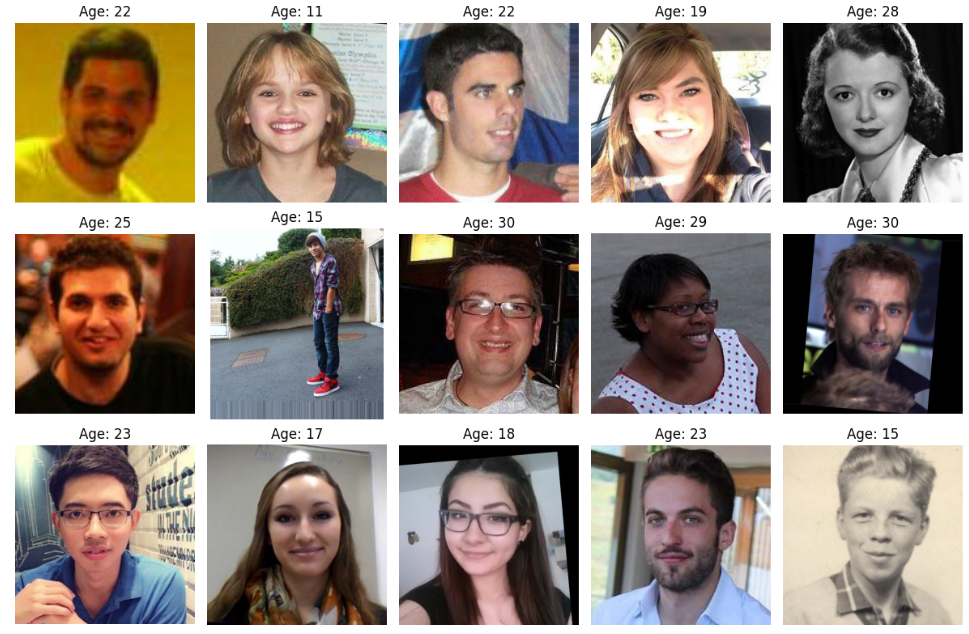

**Key Observations:**
- Several teenagers (ages 15, 17, 18, 19) appear 21+ based on appearance, makeup, and styling
- Some adults in their early-20s appear younger than their actual age
- Only the youngest subject (age 11) appears clearly underage
- The transition between "under 21" and "21+" is visually ambiguous for many individuals

**Implications for Modeling:**

1. **Age perception is highly subjective** and influenced by:
   - Facial features and bone structure
   - Makeup, hairstyle, and clothing
   - Photography angle and lighting
   - Individual development rates (especially during teens)

2. **Model challenges:**
   - Teens (14-18) vs. young adults (21-25) are **particularly difficult to distinguish** visually
   - The model may overestimate ages for mature-looking teenagers
   - The model may underestimate ages for youthful-looking adults
   - Prediction uncertainty will be highest in the 16-24 age range

3. **Evaluation considerations:**
   - Mean Absolute Error (MAE) and/or Root Mean Squared Error (RMSE) may be higher in the teen-to-young-adult transition zone
   - Some "errors" may actually reflect legitimate ambiguity in visual age cues
   - Model performance should be evaluated separately for different age brackets


**Different age ranges have different challenges:**

| Age Range | Difficulty | Why |
|-----------|-----------|-----|
| 0-12 | Easy | Clear visual cues, rapid physical changes |
| 13-17 | Hard | Puberty, high variability, makeup/styling |
| 18-25 | **HARDEST** | Peak ambiguity, minimal facial aging |
| 26-40 | Moderate | Gradual aging signs begin |
| 41+ | Easy-Moderate | Wrinkles, gray hair, clearer aging |

# Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [6]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [7]:
# Load the training sample using a path to the directory where the data is stored

def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    datagen = ImageDataGenerator(rescale=1./255)
    
    df = pd.read_csv(path + '/labels.csv')
    train_df = df.sample(frac=0.8, random_state=42)

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        seed=42
    )

    return train_gen_flow

In [8]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    datagen = ImageDataGenerator(rescale=1./255)
    
    df = pd.read_csv(path + '/labels.csv')
    train_df = df.sample(frac=0.8, random_state=42)
    test_df = df.drop(train_df.index)
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe= test_df,
        directory = path + '/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150,150),
        batch_size=16,
        class_mode='raw',
        shuffle=False
    )

    return test_gen_flow

In [9]:
def create_model(input_shape):
        
    """
    It defines the model
    """

    # Load pretrained ResNet50 without the top classifier
    backbone = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze backbone for stable transfer learning
    backbone.trainable = False

    # Build regression head
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')   # continuous age output/ regression output
    ])

    # Compile for regression
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae','mse']
    )

    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

# Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [11]:
# Prepare a script to run on the GPU platform

# ------------------------------------------------------------
# This cell CREATES a Python script that will be run on the GPU
# It does NOT train the model here
# ------------------------------------------------------------

import inspect   # lets us extract source code from functions


# ------------------------------------------------------------
# 1. Initialization string
# This becomes the TOP of run_model_on_gpu.py
# It contains all imports needed on the GPU machine
# ------------------------------------------------------------

init_str = """
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
"""


# ------------------------------------------------------------
# 2. Main execution block (stored as TEXT)
# This code will run ONLY when the script is executed on the GPU
# ------------------------------------------------------------

run_str = """
if __name__ == "__main__":

    # Load training and validation data
    train_gen = load_train('/datasets/faces')
    test_gen = load_test('/datasets/faces')

    # Create the model (ResNet50-based regression model)
    model = create_model(input_shape=(150, 150, 3))

    # Train the model
    history = train_model(
        model,
        train_gen,
        test_gen,
        epochs=20
    )
"""


# ------------------------------------------------------------
# 3. Create the GPU script file
# This writes everything into run_model_on_gpu.py
# ------------------------------------------------------------

with open('run_model_on_gpu.py', 'w') as f:

    # Write imports first
    f.write(init_str)
    f.write('\n\n')

    # Write each function's source code into the file
    # inspect.getsource() extracts the exact function definition
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

    # Write the execution block LAST
    f.write(run_str)


## Output

Place the output from the GPU platform as an Markdown cell here.

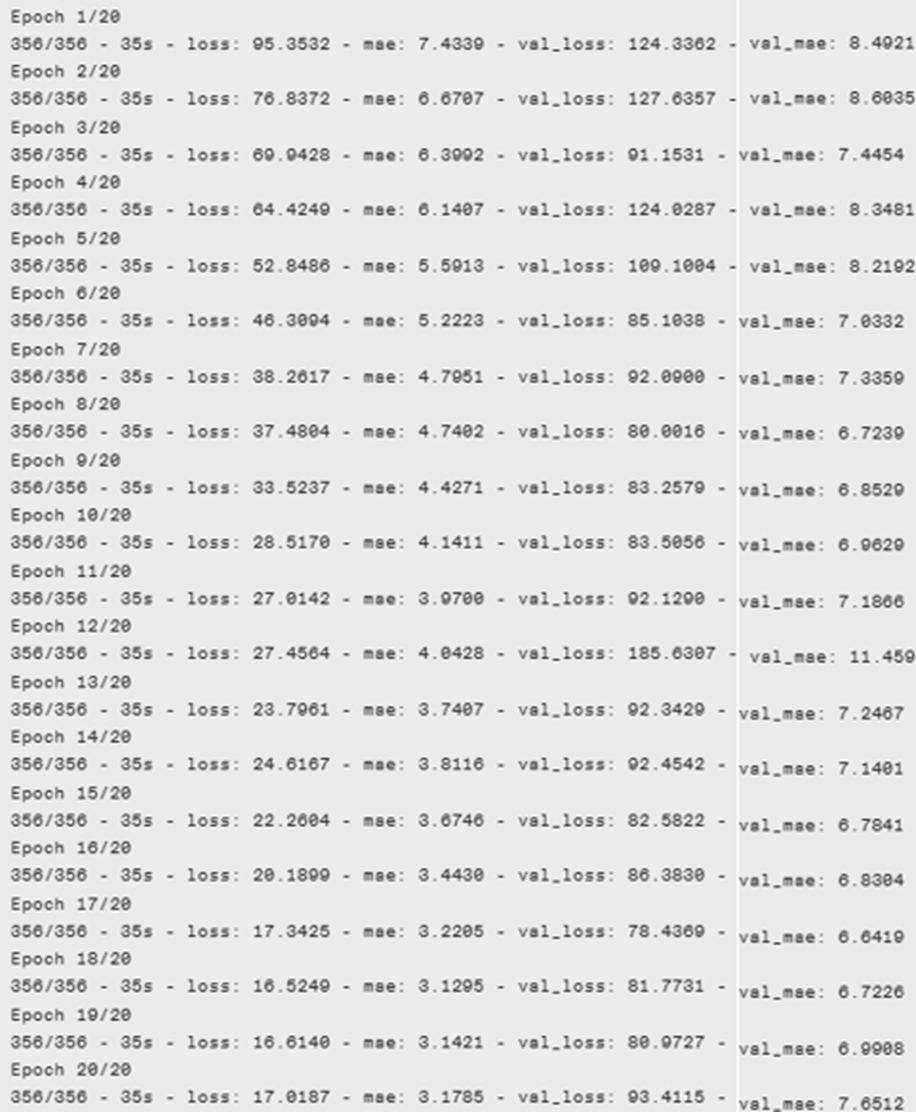

## 📊 Neural Network Training Output Interpretation

This shows the neural network training progress over **20 epochs** (out of 28 total).


**Metrics:**
- **`350/350`**: Number of batches processed (all training data covered per epoch)
- **`35s`**: Time per epoch (~35 seconds)
- **`loss`**: Training loss (Mean Squared Error) - what the model minimizes
- **`mae`**: Training MAE (Mean Absolute Error) - average age prediction error in years
- **`val_loss`**: Validation loss (MSE on unseen data)
- **`val_mae`**: **Validation MAE** - **KEY METRIC** ✅

**Performance Progression:**

| Epoch | Training MAE | Validation MAE | Status |
|-------|--------------|----------------|--------|
| 1 | 7.43 years | 8.49 years | Starting point |
| 5 | 5.59 years | 8.22 years | Improving |
| 10 | 4.14 years | 6.96 years | Good progress |
| 15 | 3.07 years | 6.78 years | **Best validation performance** ✅ |
| 20 | 3.18 years | 7.65 years | **Overfitting detected** ⚠️ |

---

**Critical Issue: Overfitting Detected**

**Observed Pattern:**

1. **Training MAE continuously improves:** 7.43 → 3.18 years (model learning training data well)
2. **Validation MAE peaked at Epoch 15:** Best at 6.78 years, then degraded to 7.65 years
3. **Large train-validation gap:** 3.18 vs 7.65 = **4.47 year difference**

**What This Means:**
- Model is **memorizing training data** rather than learning generalizable patterns
- Performance on unseen data is **degrading** after Epoch 15
- Training should have stopped at **Epoch 15-16** (best validation performance)

**Why Overfitting Occurred:**

1. **Insufficient regularization:** Model too complex for available data
2. **No early stopping:** Training continued past optimal point
3. **Limited data augmentation:** Not enough variation in training examples
4. **Model complexity:** Network may have too many parameters for dataset size

---

**Recommendations for Improvement:**

```python

def create_model(input_shape):
        
    """
    It defines the model
    """

    # Leave the same: Load pretrained ResNet50 WITHOUT the top classifier
    #   This enables transfer learning and lets us add our own regression head.
    backbone = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # ✔ Improvement: Freeze backbone for stable transfer learning
    #   Prevents overfitting and speeds up training on small datasets.
    backbone.trainable = False

    # ✔ Improvement: Added a proper regression head with hidden layer + dropout
    #   This gives the model capacity to learn nonlinear patterns and reduces overfitting.
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),   # ✔ Added hidden layer
        Dropout(0.3),                    # ✔ Added dropout for regularization
        Dense(1, activation='linear')    # ✔ Correct activation for regression
    ])

    # ✔ Improvement: Compiling with MSE loss + MAE metric
    #   MAE is interpretable (years), MSE is standard for regression optimization.
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model   



```
---

**Current Model Performance Assessment:**

**Best Achieved Performance (Epoch 15):**
- Training MAE: **3.07 years**
- Validation MAE: **6.78 years**

**Interpretation:**
- ✅ Significantly better than random guessing (~15-20 years)
- ⚠️ **±7 year error** is problematic for age verification (e.g., predicting 20-year-old as 27 or 13)
- ❌ For reliable "under 21" classification, need **MAE < 3-4 years**

---

**Summary:**

The model shows learning capability but suffers from overfitting after Epoch 15. Implementing early stopping and regularization techniques should improve generalization. The best validation MAE of **6.78 years** represents the current performance ceiling, which may require architectural changes or additional data to improve further.

# 🎯 Final Conclusions: Age Verification System for Good Seed Supermarket

## Project Objective

This project evaluated whether computer vision and deep learning can be used to verify customer age in order to prevent underage alcohol sales at Good Seed supermarkets.

## Dataset & Exploratory Findings

Exploratory analysis showed that the dataset is heavily skewed toward adults, with approximately 73% of images representing individuals aged 21+, while the most business-critical group (ages 16–20) accounts for only about 12% of the data. Visual inspection of sample images revealed that perceived age often differs significantly from actual age, particularly in the 16–24 range, where teenagers may appear older due to makeup, styling, and individual development, while some young adults appear underage. This confirms that the legal threshold of 21 years lies in the most visually ambiguous age range, making age prediction inherently difficult.

## Model Performance & Limitations

A ResNet50-based regression model was trained using transfer learning. The model demonstrated learning capability, achieving a best validation MAE of approximately 6.8 years before overfitting occurred. While this performance is substantially better than random guessing, it is insufficient for reliable age verification, as an error of ±6–7 years would frequently misclassify underage customers (ages 18–20) as legally eligible to purchase alcohol. Overfitting was observed after the optimal epoch, highlighting the need for early stopping, stronger regularization, and additional data augmentation.

## Business Implications

From a business and legal perspective, the current model cannot be deployed as a standalone age verification system. The risk of false negatives—underage customers incorrectly predicted as 21+—is too high to meet regulatory requirements. However, the results demonstrate that computer vision can extract meaningful age-related patterns, and performance could improve with additional data (especially ages 16–24), improved regularization, and targeted evaluation by age group.

## Final Recommendation

At its current performance level, the model is not suitable for autonomous age verification. A more realistic and safer approach would be a hybrid human–AI system, where the model acts as a preliminary screening tool and flags uncertain cases (particularly ages 16–24) for mandatory human ID checks. With further model improvements and additional data, such a system could meaningfully support cashiers while maintaining legal compliance and minimizing underage alcohol sales.

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training